# <center> Exercise 2  

## Import Google Earth API

In [1]:
import ee
import geemap

## Initialize the authentication process

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

Enter verification code:  4/1AfJohXk1KI38mz5hVT9XjvIXpsa9HohYtUDeH6W-jGkrfv9KNpu08AwGVF0



Successfully saved authorization token.


In [4]:
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


## Using Dask  


In [5]:
import dask.dataframe as dd
import pandas as pd

In [6]:
df = dd.read_csv('Data/SamplesSet*.csv')
print(df.head())
print(df.tail())

         lat        lon           landcover
0  66.186422  19.580600  ForestNaturalAreas
1  67.225224  22.139060  ForestNaturalAreas
2  68.564587  18.763001  ForestNaturalAreas
3  51.756201  24.713687               Water
4  47.705336  18.825144    AgriculturalArea
            lat        lon           landcover
4152  42.635008   4.372315               Water
4153  53.772584  -1.064018  ForestNaturalAreas
4154  40.468550   6.757071    AgriculturalArea
4155  51.167547  13.863001    AgriculturalArea
4156  56.511879  15.309247    AgriculturalArea


## Reindexing

In [7]:
df = dd.read_csv('Data/SamplesSet*.csv')
df = df.compute()
df = df.reset_index(drop=True)
print(df.tail())

             lat        lon           landcover
40456  42.635008   4.372315               Water
40457  53.772584  -1.064018  ForestNaturalAreas
40458  40.468550   6.757071    AgriculturalArea
40459  51.167547  13.863001    AgriculturalArea
40460  56.511879  15.309247    AgriculturalArea


## Data exploration

In [8]:
distinct_values = df['landcover'].drop_duplicates()
print(distinct_values)
distinct_value_counts = df['landcover'].value_counts()
print(distinct_value_counts)

0       ForestNaturalAreas
3                    Water
4         AgriculturalArea
7                 Wetlands
14      ArtificialSurfaces
1299                   NaN
Name: landcover, dtype: object
ForestNaturalAreas    15944
AgriculturalArea      13788
Water                  8494
ArtificialSurfaces     1415
Wetlands                816
Name: landcover, dtype: int64


In [8]:
min_value_lat = df['lat'].min()
max_value_lat = df['lat'].max()

min_value_lon = df['lon'].min()
max_value_lon= df['lon'].max()

print(f"The lat min value is: {min_value_lat} and max: {max_value_lat}")
print(f"The lat min value is: {min_value_lon} and max: {max_value_lon}")

The lat min value is: 36.20076975509693 and max: 71.52708720156912
The lat min value is: -26.068806183526306 and max: 41.39790973452674


## The bounding box list

Find in which bounding box lies the majority of points, using the bounding box from comment by hduchesn on github in thread https://gist.github.com/graydon/11198540

In [9]:
import json

with open('bounding_boxes.json', 'r') as file:
    bounding_boxes = json.load(file)

In [10]:
# check if in bouding box
def is_in_bounding_box(lat, lon, bounding_box):
    sw = bounding_box['sw']
    ne = bounding_box['ne']
    return sw['lat'] <= lat <= ne['lat'] and sw['lon'] <= lon <= ne['lon']


dfs = []

# count locations in each bounding box
for code, box in bounding_boxes.items():
    country_name = code
    bounding_box = box
    min_lat, min_lon = bounding_box['sw']['lat'], bounding_box['sw']['lon']
    max_lat, max_lon = bounding_box['ne']['lat'], bounding_box['ne']['lon']
    filtered_df = df[df.apply(lambda row: is_in_bounding_box(row['lat'], row['lon'], bounding_box), axis=1)]
    count = len(filtered_df)
    bounding_box_df = dd.from_pandas(pd.DataFrame({'Country': [country_name], 'Code': [code], 'Count': [count]}), npartitions=1)
    dfs.append(bounding_box_df)

counts_df = dd.concat(dfs)

## Plotting Top 20 Countries based on the sample count

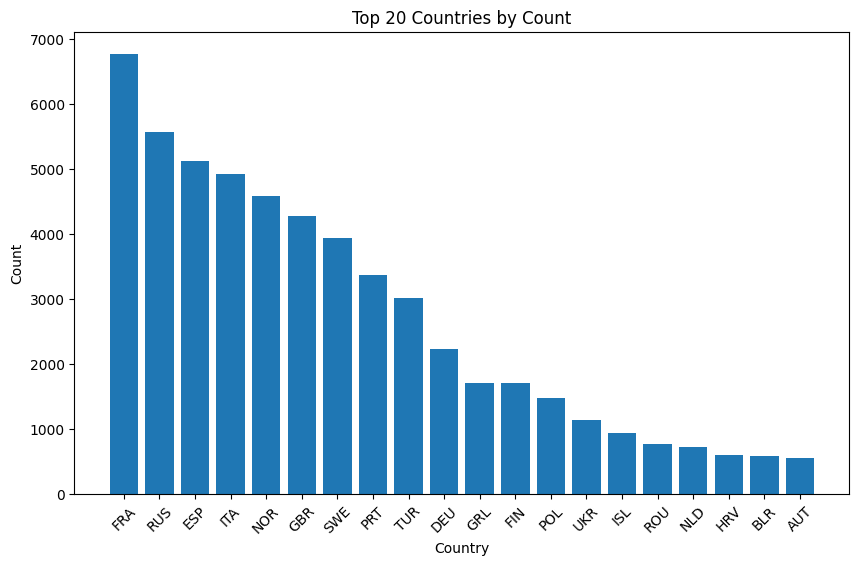

In [11]:
import matplotlib.pyplot as plt

top_scores = counts_df.nlargest(20, 'Count')
top_scores_pd = top_scores.compute()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_scores_pd['Country'], top_scores_pd['Count'])
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 20 Countries by Count')
plt.xticks(rotation=45)
plt.show()

## Get only the sample points in France

In [12]:
min_latitude = 41.303
max_latitude = 51.124
min_longitude = -5.142
max_longitude = 9.561

# Filter points within the bounding box
france_points = df[
    (df['lat'] >= min_latitude) & 
    (df['lat'] <= max_latitude) & 
    (df['lon'] >= min_longitude) & 
    (df['lon'] <= max_longitude)
]

france_points = france_points.reset_index(drop=True)

#check how many points are there in total
print(france_points.tail())

            lat       lon           landcover
6333  45.997465  0.743937  ForestNaturalAreas
6334  44.776113  0.357572    AgriculturalArea
6335  51.094544  4.601532    AgriculturalArea
6336  42.310443  6.377444               Water
6337  42.635008  4.372315               Water


**As at this point we were expecting that the number of the points and the size of the area might be too large to compute we also decided to created smaller bounding box for France**

In [13]:
bounding_box_smaller = ee.Geometry.Rectangle([-3.142, 43.303, 6.561, 49.124])

In [14]:
min_latitude = 43.303
max_latitude = 49.124
min_longitude = -3.142
max_longitude = 6.561

# Filter points within the bounding box
france_points_small = df[
    (df['lat'] >= min_latitude) & 
    (df['lat'] <= max_latitude) & 
    (df['lon'] >= min_longitude) & 
    (df['lon'] <= max_longitude)
]

france_points_small = france_points_small.reset_index(drop=True)

print(france_points_small.tail())

            lat       lon           landcover
2692  48.719424  3.488222  ForestNaturalAreas
2693  44.669344  0.413262    AgriculturalArea
2694  47.536590  2.006475    AgriculturalArea
2695  45.997465  0.743937  ForestNaturalAreas
2696  44.776113  0.357572    AgriculturalArea


## Sentinel image  


In [17]:
# get the image for the bigger France area
bounding_box = ee.Geometry.Rectangle([-5.4534286, 41.2632185, 9.8678344, 51.268318])
center = bounding_box.centroid()

map_france = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
  .filterBounds(bounding_box)\
  .filterDate('2023-06-01', '2023-08-30')\
  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 30) \
  .sort('CLOUDY_PIXEL_PERCENTAGE', False)


## Data Interrogation

In [18]:
# get number of images in collection
listOfImages = map_france.aggregate_array('system:index').getInfo()
print('Number of images in the collection: ', len(listOfImages))


Number of images in the collection:  3007


In [19]:
# Set visualization parameters for land cover R, G, B
vis_params = {"min": 0, 
              "max": 4000, 
              "bands": ["B4", "B3", "B2"]}  

# calculate the median of the image
median_image = map_france.median()

In [20]:
#initialize and display the original map
Map = geemap.Map()
Map.addLayer(median_image, vis_params, "Median", True) 
Map.centerObject(center, 5)
Map

Map(center=[46.36657487868256, 2.207202899999996], controls=(WidgetControl(options=['position', 'transparent_b…

In [21]:
# get the available bands 
bandNames = median_image.bandNames() 
print('Band names: ', bandNames.getInfo()) # ee.List of band names 

Band names:  ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']


## Proceed with Clustering

## Start training


In [22]:
%%time
training = median_image.sample(**{
    'region':bounding_box,
    'scale': 30,
    'numPixels': 10000,
    'seed': 0,
    'tileScale' : 2,
    'geometries': True # the geometries are not included
})

CPU times: user 69 µs, sys: 1 µs, total: 70 µs
Wall time: 74.4 µs


## Display the training results

In [23]:
Map.addLayer(training, {}, 'training', False)
Map

Map(bottom=3202.0, center=[46.36657487868256, 2.207202899999996], controls=(WidgetControl(options=['position',…

## Cluster the results

In [24]:
%time
n_clusters = 5
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer.
result = median_image.cluster(clusterer)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 21.7 µs


## Display the cluster map

In [26]:
#palette = [red, green, blue, yellow, magenta]
palette = ['ff0000', '00ff00', '0000ff', 'ffff00', 'ff00ff'] # Add or modify colors as needed

# Create a visualization parameter with the specified palette
vis_params = {'min': 0, 'max': n_clusters - 1, 'palette': palette}

# Add the clustered result to the map using the custom visualization parameters
Map.addLayer(result, vis_params, 'clusters')

Map

Map(bottom=3215.0, center=[45.98169518512228, 7.141113281250001], controls=(WidgetControl(options=['position',…

# Assessing the performance  

Getting the value of the cluster in the location of the point present in a data set for the biggest area of France

In [ ]:
def get_cluster_for_coordinates(lat, lon):
    point = ee.Geometry.Point(lon, lat)
    cluster = result.reduceRegion(ee.Reducer.first(), point, 80)  # Adjust the scale as needed
    return cluster.get('cluster').getInfo()

france_points['cluster'] = france_points.apply(lambda row: get_cluster_for_coordinates(row['lat'], row['lon']), axis=1)
france_points.head()


**The library pickle is used so that all the resulting data frames can be saved. Therefore in the following part of the report the code will not be shown. Only the resulting maps and histograms as the code for training, clustering and checking the performance remains the same (only the parameters change)**

In [ ]:
# library to save variables
import pickle

In [ ]:
with open('france_points_big.pickle', 'wb') as handle:
    pickle.dump(france_points, handle)

## Histogram  


In [ ]:
grouped_data = france_points.groupby(['cluster', 'landcover']).size().reset_index(name='count')

# Pivot the data to create a table suitable for plotting
pivot_data = grouped_data.pivot(index='cluster', columns='landcover', values='count').fillna(0)

colors = {
    'Water': 'blue',
    'ForestNaturalAreas': 'green',
    'ArtificialSurfaces': 'grey',
    'Wetlands': 'purple',
    'AgriculturalArea': '#FFD700'
}

# Plotting with custom colors
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Points per Cluster for Each Landcover')
plt.show()

In [ ]:
map_france_small = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
  .filterBounds(bounding_box_smaller)\
  .filterDate('2023-06-01', '2023-08-30')\
  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 30)


bands_of_interest = ['B2', 'B3', 'B4']  

map_smaller = map_france_small.select(bands_of_interest)
map_smaller_median = map_smaller.median()

<div align="center">
  <img src="images/france_bands.png" alt="Image Description" width="70%">
</div>

## Poland

In [ ]:
# Coordinates for the box
min_latitude = 49.0020468
max_latitude = 55.0336963
min_longitude = 14.1229707
max_longitude = 24.145783


# Filter points within the bounding box
pol_points = df[
    (df['lat'] >= min_latitude) & 
    (df['lat'] <= max_latitude) & 
    (df['lon'] >= min_longitude) & 
    (df['lon'] <= max_longitude)
]

pol_points = pol_points.reset_index(drop=True)
pol_points.tail()

### Reducing the Bounding Box size and increasing the training size  


In [ ]:
bounding_box_poland_10k = ee.Geometry.Rectangle([18, 51, 21, 53])


training_pol = median_pol_10k.sample(**{
    'region':bounding_box_poland_10k,
    'scale': 30,
    'numPixels': 100000, # was 500
    'seed': 0,
    'tileScale' : 8,
    'geometries': True # the geometries are not included
})

In [ ]:
bounding_box_poland_10k_smaller = ee.Geometry.Rectangle([19, 51, 20, 52])

**The results**

<div style="display: flex; justify-content: center;">
  <img src="images/PolR2.png" alt="Image 1" style="width: 49%; margin: 0 10px;">
  <img src="images/PolR3.png" alt="Image 2" style="width: 49%; margin: 0 10px;">
</div>

<div style="display: flex; justify-content: center;">
  <img src="images/PolR9.png" alt="Image 1" style="width: 49%; margin: 0 10px;">
  <img src="images/PolR15.png" alt="Image 2" style="width: 49%; margin: 0 10px;">
</div>